# Imports and Functions

In [14]:
# Initialization Cell
path_data = 'C:\\Users\\under\\Jupyter Projects\\My Research\\Donor Charity Matching\\data_donorschoose\\donorschoose_all.csv'

In [15]:
# Imports
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import recall_score

In [16]:
import time
def print_time(start_time, opeartion):
    total = time.time() - start_time
    print('In total,', opeartion, 'takes:', int(total/60), 'minute and', int(total%60), 'seconds')

# Data Pre-processing

In [17]:
df_all = pd.read_csv(path_data)

In [19]:
# Combine all the text information into one column
df_all['all_texts'] = df_all['essay'] + df_all['title'] + df_all['short_description'] + df_all['need_statement']

# Remove rows without any text information
df_all = df_all.dropna(subset=['all_texts'])

# Reduce the classes into 'completed' and expired
print(Counter(df_all['funding_status']))
df_all.drop(df_all[df_all['funding_status']=='reallocated'].index, inplace=True) 
df_all.drop(df_all[df_all['funding_status']=='live'].index, inplace=True) 
print(Counter(df_all['funding_status']))

# To keep consistency, only use projects created in 2014
df_2014 = df_all[df_all['date_posted'].str.slice(0,4) == '2014']
print(Counter(df_2014['funding_status']))

Counter({'completed': 796082, 'expired': 333217, 'live': 63221, 'reallocated': 9077})
Counter({'completed': 796082, 'expired': 333217})
Counter({'completed': 117899, 'expired': 51176})


# Text Preprocessing

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re, string
    
def removePunctuation(sentence):
    return sentence.translate(str.maketrans(' ', ' ',string.punctuation))

def removeDigit(sentence):
    digit_removed = re.sub(r'\d+', '', sentence)
    return digit_removed

nltk.download('stopwords')
def removeStopWords(sentence):
    stop_words = set(stopwords.words('english'))
    return list(filter(lambda x: x not in stop_words, sentence.split()))

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatizeDoc(sentence):
    return list(map(lambda x: lemmatizer.lemmatize(x), sentence.split()))    

def convertWordsToString(word_list):
    sentence = ' '.join(word_list)
    return sentence

def clean_corpora(doc_list):
    start_time = time.time()
    # Lower all texts
    doc_list = doc_list.str.lower()
    # Remove all digits
    doc_list = doc_list.apply(removeDigit)
    # Remove punctuations
    doc_list = doc_list.apply(removePunctuation)
    # Remove Stopwords
    doc_list = doc_list.apply(removeStopWords)
    # Convert splitted words list into sentence
    doc_list = doc_list.apply(convertWordsToString)
    # Lemmatize text
    doc_list = doc_list.apply(lemmatizeDoc)
    # Convert splitted words list into sentence
    doc_list = doc_list.apply(convertWordsToString)
    print_time(start_time, 'Clean corpora')
    return doc_list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\under\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\under\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
# Vectorize texts into bigram terms
from sklearn.feature_extraction.text import TfidfVectorizer

X_texts = clean_corpora(df_2014['all_texts'])
start_time = time.time()
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1, 2), norm='l2')
X_bigram = vectorizer.fit_transform(X_texts)
print_time(start_time, 'Vectorizing documents')
print('The number of bigram terms:', X_bigram.shape[1])

In total, Clean corpora takes: 6 minute and 38 seconds
In total, Vectorizing documents takes: 3 minute and 21 seconds
The number of bigram terms: 4440619


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert labels into binary values
y =LabelEncoder().fit_transform(df_2014['funding_status'])
# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_bigram, y, test_size=0.2, random_state=42)

# The classifier with the best f1-score
## *below codes are the process took to find this best classifier

F1 macro with 200000 features: 0.8602213446443372


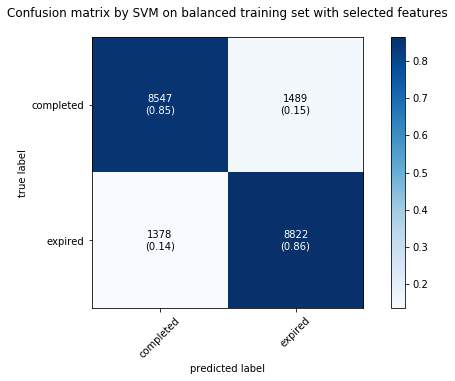

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import LinearSVC

bestk = SelectKBest(score_func=chi2, k=200000)
X_reduced = bestk.fit_transform(X_bigram_balanced, y_balanced)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_balanced, test_size=0.2, random_state=42)
svc = LinearSVC(C=5.0, class_weight=None, dual=True, fit_intercept=True,
                intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
f1 = f1_score(y_test, pred_svc, average='binary')
print('F1 macro with', 200000, 'features:', f1)

plot_confusion_matrix(conf_mat=confusion_matrix(y_test, pred_svc)
                     ,show_absolute=True
                     ,show_normed=True
                     ,colorbar=True
                     ,class_names=['completed', 'expired']
                     ,figsize=(10, 5))
plt.title('Confusion matrix by SVM on balanced training set with selected features')
plt.show()

# SVM with All the Features
## *analysis: too many features to learn any pattern

In [43]:
svc = LinearSVC(C=5.0, class_weight=None, dual=True, fit_intercept=True,
                intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)

F1 macro: 0.20824995158479118


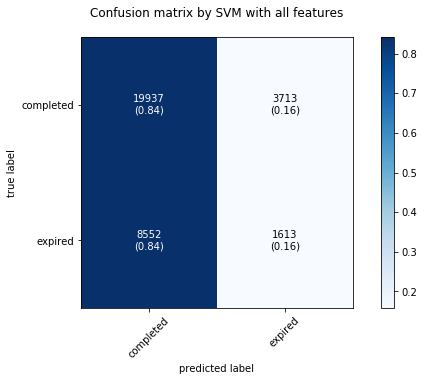

In [44]:
f1 = f1_score(y_test, pred_svc, average='binary')
print('F1 macro:', f1)

plot_confusion_matrix(conf_mat=confusion_matrix(y_test, pred_svc)
                     ,show_absolute=True
                     ,show_normed=True
                     ,colorbar=True
                     ,class_names=['completed', 'expired']
                     ,figsize=(10, 5))
plt.title('Confusion matrix by SVM with all features')
plt.show()

# Feature Selection by Chi-square test

In [26]:
# Reduce the number of features into 10000 (originally there are more than 4 million features)
bestk = SelectKBest(score_func=chi2, k=10000)
X_reduced = bestk.fit_transform(X_bigram, y)
print('# of bigram terms:', X_reduced.shape[1])

# of bigram terms: 10000


In [29]:
# Construct a dictionary of selected features with their chi-sqaure score
mask = bestk.get_support() 
new_features = {} 
for b, feature, score in zip(mask, vectorizer.get_feature_names(), bestk.scores_):
    if b:
        new_features.update({feature:score})

# Print top x features
num_show = 10
sorted(new_features.items(), key=lambda x: x[1])[::-1][:num_show]

[('salmon', 3.0578850965252213),
 ('dumbbell', 2.7488480778830686),
 ('pig heart', 2.6020733395652615),
 ('dressup', 2.4323031265464077),
 ('braidy', 2.340708083554492),
 ('youth art', 2.339924861030455),
 ('activity chest', 2.2493667176992385),
 ('put well', 2.150858431067736),
 ('athletic training', 2.112817435118616),
 ('empty bowl', 2.0835101973988968)]

# Plain SVM with selected features
## * found imbalanced data issue from confusion matrix

In [32]:
num_terms = [10, 100, 1000, 2000, 3000, 5000, 7000, 10000, 20000, 50000, 70000, 100000, 150000, 200000, 250000, 400000, 500000, 1000000]
f1_scores = []
recall_class0 = []
recall_class1 = []
svc = LinearSVC(C=5.0, class_weight=None, dual=True, fit_intercept=True,
                         intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                         multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

for k in num_terms:
    # Select top k features
    bestk = SelectKBest(score_func=chi2, k=k)
    X_reduced = bestk.fit_transform(X_bigram, y)
    # Split the dataset into the training and test
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
    # Train a clf with reduced number of features
    svc.fit(X_train, y_train)
    pred_svc = svc.predict(X_test)
    # Calculate f1-score and store it into list
    f1 = f1_score(y_test, pred_svc, average='binary')
    f1_scores.append(f1)
    # Calculate the recall of each class and store them into list
    recalls = recall_score(y_test, pred_svc, average=None)
    recall_class0.append(recalls[0])
    recall_class1.append(recalls[1])
    print('F1 macro with', k, 'features:', f1)

F1 macro with 10 features: 0.0015720180782078993
F1 macro with 100 features: 0.011905923684980972
F1 macro with 1000 features: 0.06148316307226636
F1 macro with 2000 features: 0.09037765611951377
F1 macro with 3000 features: 0.11162960929636746
F1 macro with 5000 features: 0.14126927214055218
F1 macro with 7000 features: 0.1660197600564573
F1 macro with 10000 features: 0.19899723374827108
F1 macro with 20000 features: 0.2612889812889813
F1 macro with 50000 features: 0.3306986027944112
F1 macro with 70000 features: 0.3487414912141839
F1 macro with 100000 features: 0.3607769127938979
F1 macro with 150000 features: 0.37180189343556846
F1 macro with 200000 features: 0.4095469747643661
F1 macro with 250000 features: 0.42888173170549015
F1 macro with 400000 features: 0.42123546292100894
F1 macro with 500000 features: 0.4137826120027383
F1 macro with 1000000 features: 0.37318330989217063


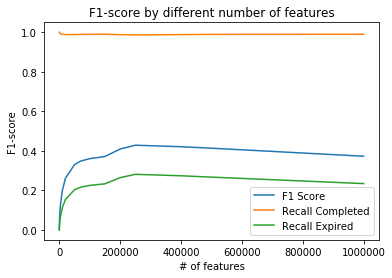

In [35]:
plt.plot(num_terms, f1_scores, label='F1 Score')
plt.plot(num_terms, recall_class0, label='Recall Completed')
plt.plot(num_terms, recall_class1, label='Recall Expired')
plt.title('F1-score by different number of features')
plt.ylabel('F1-score')
plt.xlabel('# of features')
plt.legend()
plt.show()

F1 macro with 250000 features: 0.42888173170549015


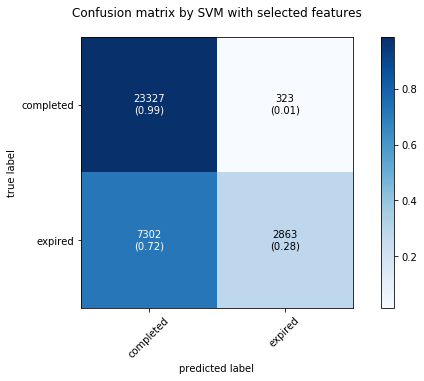

In [40]:
bestk = SelectKBest(score_func=chi2, k=250000)
X_reduced = bestk.fit_transform(X_bigram, y)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
svc = LinearSVC(C=5.0, class_weight=None, dual=True, fit_intercept=True,
                intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
f1 = f1_score(y_test, pred_svc, average='binary')
print('F1 macro with', 250000, 'features:', f1)

plot_confusion_matrix(conf_mat=confusion_matrix(y_test, pred_svc)
                     ,show_absolute=True
                     ,show_normed=True
                     ,colorbar=True
                     ,class_names=['completed', 'expired']
                     ,figsize=(10, 5))
plt.title('Confusion matrix by SVM with selected features')
plt.show()

# Cost-sensitive SVM with Selected Features
## *analysis: improves the recall of minority class while preserving the performance on the majority class

In [41]:
num_terms = [10, 100, 1000, 2000, 3000, 5000, 7000, 10000, 20000, 50000, 70000, 100000, 150000, 200000, 250000, 400000, 500000, 1000000]
f1_scores = []
recall_class0 = []
recall_class1 = []
svc_weighted = LinearSVC(C=5.0, class_weight='balanced', dual=True, fit_intercept=True,
                         intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                         multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

for k in num_terms:
    # Select top k features
    bestk = SelectKBest(score_func=chi2, k=k)
    X_reduced = bestk.fit_transform(X_bigram, y)
    # Split the dataset into the training and test
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
    # Train a cost-sensitive clf with reduced number of features
    svc_weighted.fit(X_train, y_train)
    pred_svc = svc_weighted.predict(X_test)
    # Calculate f1-score and store it into list
    f1 = f1_score(y_test, pred_svc, average='binary')
    f1_scores.append(f1)
    # Calculate the recall of each class and store them into list
    recalls = recall_score(y_test, pred_svc, average=None)
    recall_class0.append(recalls[0])
    recall_class1.append(recalls[1])
    print('F1 macro with', k, 'features:', f1)

F1 macro with 10 features: 0.0045036224789504605
F1 macro with 100 features: 0.048402167819099236
F1 macro with 1000 features: 0.22428304239401498
F1 macro with 2000 features: 0.32533446591633036
F1 macro with 3000 features: 0.3919399446858949
F1 macro with 5000 features: 0.4636794433447304
F1 macro with 7000 features: 0.5114887370857563
F1 macro with 10000 features: 0.540966893813382
F1 macro with 20000 features: 0.5782407904628935
F1 macro with 50000 features: 0.6206780986426855
F1 macro with 70000 features: 0.623565503920009
F1 macro with 100000 features: 0.6240935672514619
F1 macro with 150000 features: 0.6204862782859895
F1 macro with 200000 features: 0.631204390567517
F1 macro with 250000 features: 0.6307179642532565
F1 macro with 400000 features: 0.6088377647872273
F1 macro with 500000 features: 0.5956900974858902
F1 macro with 1000000 features: 0.5327433628318584


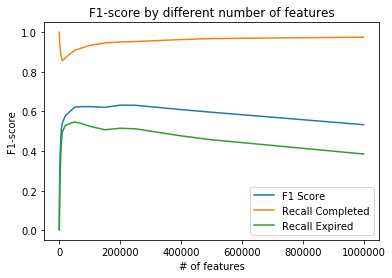

In [45]:
plt.plot(num_terms, f1_scores, label='F1 Score')
plt.plot(num_terms, recall_class0, label='Recall Completed')
plt.plot(num_terms, recall_class1, label='Recall Expired')
plt.title('F1-score by different number of features')
plt.ylabel('F1-score')
plt.xlabel('# of features')
plt.legend()
plt.show()

F1 macro with 500000 features: 0.6285779320548568


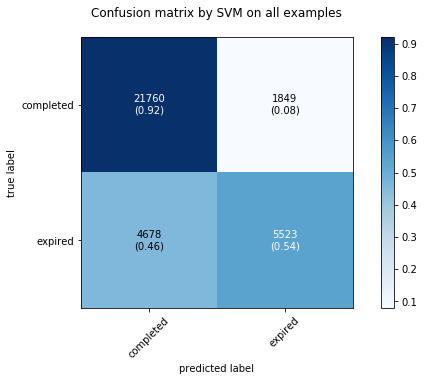

In [16]:
bestk = SelectKBest(score_func=chi2, k=70000)
X_reduced = bestk.fit_transform(X_bigram, y)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
svc_weighted = LinearSVC(C=5.0, class_weight='balanced', dual=True, fit_intercept=True,
    intercept_scaling=1, loss='squared_hinge', max_iter=1000,
    multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)
svc_weighted.fit(X_train, y_train)
pred_svc = svc_weighted.predict(X_test)
f1 = f1_score(y_test, pred_svc, average='binary')
print('F1 macro with', k, 'features:', f1)

plot_confusion_matrix(conf_mat=confusion_matrix(y_test, pred_svc)
                     ,show_absolute=True
                     ,show_normed=True
                     ,colorbar=True
                     ,class_names=['completed', 'expired']
                     ,figsize=(10, 5))
plt.title('Confusion matrix by SVM on all examples')
plt.show()

# SVM on Balanced Dataset
## *under-samling approach: manually reduce the number of examples in the majority class
## *analysis: dramatically improve the recall of the minority class while little bit sacrificing the recall of majority class 

In [25]:
# Randomly select 50000 examples from the majority class
df_2014_random = df_2014[df_2014['funding_status']=='completed'].sample(n=50000, random_state=42)
df_2014_random = pd.concat([df_2014_random, df_2014[df_2014['funding_status']=='expired']], axis=0)
df_2014_random.shape

(101176, 89)

In [26]:
# Vectorize the new text set
X_texts = clean_corpora(df_2014_random['all_texts'])
start_time = time.time()
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1, 2), norm='l2')
X_bigram_balanced = vectorizer.fit_transform(X_texts)
print_time(start_time, 'Vectorizing documents')

y_balanced = LabelEncoder().fit_transform(df_2014_random['funding_status'])

In total, Clean corpora takes: 5 minute and 2 seconds
In total, Vectorizing documents takes: 2 minute and 8 seconds


In [58]:
num_terms = [10, 100, 1000, 2000, 3000, 5000, 7000, 10000, 20000, 50000, 70000, 100000, 150000, 200000, 250000, 400000, 500000, 1000000]
f1_scores = []
recall_class0 = []
recall_class1 = []
svc = LinearSVC(C=5.0, class_weight=None, dual=True, fit_intercept=True,
                intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

for k in num_terms:
    # Select top k features
    bestk = SelectKBest(score_func=chi2, k=k)
    X_reduced = bestk.fit_transform(X_bigram_balanced, y_balanced)
    # Split the dataset into the training and test
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_balanced, test_size=0.2, random_state=42)
    # Train a clf with reduced number of features
    svc.fit(X_train, y_train)
    pred_svc = svc.predict(X_test)
    # Calculate f1-score and store it into list
    f1 = f1_score(y_test, pred_svc, average='binary')
    f1_scores.append(f1)
    # Calculate the recall of each class and store them into list
    recalls = recall_score(y_test, pred_svc, average=None)
    recall_class0.append(recalls[0])
    recall_class1.append(recalls[1])
    print('F1 macro with', k, 'features:', f1)

F1 macro with 10 features: 0.6662221184943153
F1 macro with 100 features: 0.6662167633958699
F1 macro with 1000 features: 0.6749221522195669
F1 macro with 2000 features: 0.6801132617043558
F1 macro with 3000 features: 0.688026437754403
F1 macro with 5000 features: 0.7003010752688172
F1 macro with 7000 features: 0.7139557608599094
F1 macro with 10000 features: 0.7298203702852943
F1 macro with 20000 features: 0.7729357798165138
F1 macro with 50000 features: 0.8206772579313026
F1 macro with 70000 features: 0.8357831208021026
F1 macro with 100000 features: 0.8490804709545586
F1 macro with 150000 features: 0.8572682070780929
F1 macro with 200000 features: 0.8602213446443372
F1 macro with 250000 features: 0.8616523772408419
F1 macro with 400000 features: 0.861895702229377
F1 macro with 500000 features: 0.85694783032667
F1 macro with 1000000 features: 0.8323306811566078


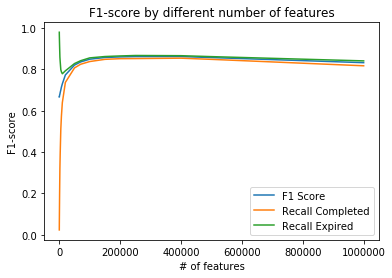

In [59]:
plt.plot(num_terms, f1_scores, label='F1 Score')
plt.plot(num_terms, recall_class0, label='Recall Completed')
plt.plot(num_terms, recall_class1, label='Recall Expired')
plt.title('F1-score by different number of features')
plt.ylabel('F1-score')
plt.xlabel('# of features')
plt.legend()
plt.show()

F1 macro with 1000000 features: 0.8602213446443372


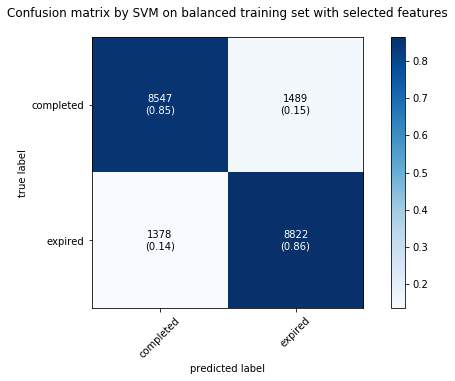

In [60]:
bestk = SelectKBest(score_func=chi2, k=200000)
X_reduced = bestk.fit_transform(X_bigram_balanced, y_balanced)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_balanced, test_size=0.2, random_state=42)
svc = LinearSVC(C=5.0, class_weight=None, dual=True, fit_intercept=True,
                intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
f1 = f1_score(y_test, pred_svc, average='binary')
print('F1 macro with', k, 'features:', f1)

plot_confusion_matrix(conf_mat=confusion_matrix(y_test, pred_svc)
                     ,show_absolute=True
                     ,show_normed=True
                     ,colorbar=True
                     ,class_names=['completed', 'expired']
                     ,figsize=(10, 5))
plt.title('Confusion matrix by SVM on balanced training set with selected features')
plt.show()